# Immersion configuration of Ultrasonic data

Lars Gebraad

_Copyright Mondaic AG, for the University of Bristol, January 2025._

This tutorial will showcases how Salvus can be used to model layered 3D structures.

In [1]:
import dataclasses

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Main Salvus import
import salvus.namespace as sn

SITE_NAME = "local"
RANKS = 8

CENTRAL_FREQUENCY = 1.5e6  # MHz

PROJECT_NAME = f"project_03_{int(CENTRAL_FREQUENCY)}"

--> Server: 'https://l.mondaic.com/licensing_server', User: 'lars.gebraad', Group: 'mondaic_support'.
--> Negotiating 1 license instance(s) for 'SalvusMesh' [license version 1.0.0] for 1 seconds ...
--> Success! [Total duration: 0.55 seconds]


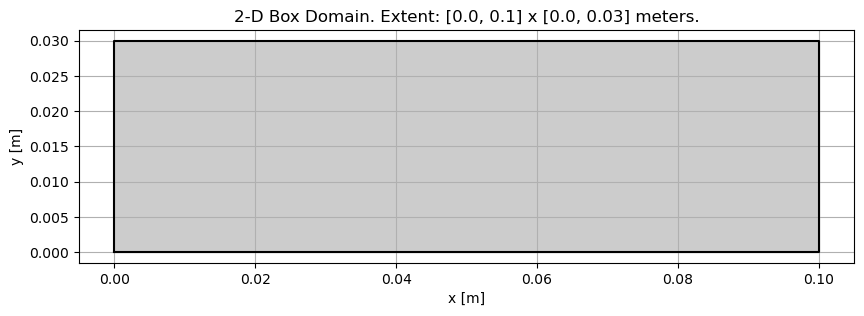

In [2]:
domain = sn.domain.dim2.BoxDomain(x0=0.0, x1=0.1, y0=0.0, y1=0.03)

domain.plot()

In [3]:
# Once we have a domain we can initialize a project with a path on disk.
p = sn.Project.from_domain(
    path=PROJECT_NAME, domain=domain, load_if_exists=True
)

Accordion()

## Creating coupled acoustic-elastic models

In [23]:
y_transducers = ((0.03 - interface_depth) + (0.03) ) /2

y_transducers

0.027499999999999997

In [36]:
import salvus.mesh.layered_meshing as lm
import salvus.mesh

interface_depth = 0.005

layered_model = lm.LayeredModel(
    [
        lm.material.acoustic.Velocity.from_params(rho=1450.0, vp=1500.0),
        lm.interface.Hyperplane.at(lm.interface.Depth(interface_depth)),
        lm.material.elastic.Velocity.from_params(
            rho=2600.0, vp=5000.0, vs=5000.0 / np.sqrt(3)
        ),
    ]
)

layered_model_absorbing_boundaries = sn.layered_meshing.MeshingProtocol(
    layered_model,
    ab=salvus.mesh.simple_mesh.basic_mesh.AbsorbingBoundaryParameters(
        free_surface=False,#["y1"],
        number_of_wavelengths=1.5,
        reference_velocity=5000,
        reference_frequency=CENTRAL_FREQUENCY * 2,
    ),
)

mesh = lm.mesh_from_domain(
    domain=domain,
    model=layered_model_absorbing_boundaries,
    mesh_resolution=sn.MeshResolution(
        reference_frequency=CENTRAL_FREQUENCY * 2, elements_per_wavelength=2
    ),
)

mesh_no_anomaly = mesh.copy()

# Add strong scatterer AFTER meshing
for scatterer_center in [np.array([x, 0.01]) for x in [0.03, 0.05, 0.07]]:
    distance_from_scatterer = np.linalg.norm(
        mesh.get_element_centroid() - scatterer_center, axis=1
    )
    radius = 0.00125
    anomaly = distance_from_scatterer < radius
    mesh.elemental_fields["RHO"] -= anomaly[:, None] * 2400
    mesh.elemental_fields["VP"] -= anomaly[:, None] * 500
    mesh.elemental_fields["VS"] -= anomaly[:, None] * 500

mesh

## Creating a line-scan configuration

In [37]:
@dataclasses.dataclass
class ArrayTransducer2D:
    # Represents a rectangular array transducer.
    nx: int
    dx: float
    x0: float

    # Update this per array if you want to add multiple, as the
    # receivers will use this name to identify themselves
    array_name: str = "array_0"

    # Note that because these are placed in an acoustic medium, they
    # must record one of the acoustic fields!
    recording_fields: list[str] = dataclasses.field(
        default_factory=lambda: ["phi"]
    )

    # Determines on what side of the domain the array is attached
    side_set: str = "y1"

    def test_within_domain(self, domain: sn.domain.Domain) -> bool:
        # Determines whether the entire grid of the array transducer
        # is within a given domain.
        x_bounds = domain.bounds.hc["x"]

        # Calculate the spatial bounds of the array transducer
        array_x_bounds = (self.x0, self.x0 + (self.nx - 1) * self.dx)

        # Check if the array is fully within the domain bounds
        within_x = (
            x_bounds[0] <= array_x_bounds[0]
            and array_x_bounds[1] <= x_bounds[1]
        )

        return within_x

    def create_salvus_source_receivers(
        self,
        source_index: int,
        f_source: int = 1,
    ):
        # Function to create salvus sources and receivers from array
        if source_index < 0 or source_index > self.nx - 1:
            raise ValueError("Source index out of range.")

        array_coordinates = np.zeros((self.nx))
        for i in range(self.nx):
            array_coordinates[i] = self.x0 + i * self.dx

        # Calculate all sources
        source_x = array_coordinates[source_index]

        source = sn.simple_config.source.cartesian.ScalarPoint2D(
            # Note that this 0 for Y is used for starting the projection
            # on the side set, it is not the coordinate of the source.
            x=source_x,
            y=y_transducers,
            f=f_source,
        )

        receivers = [
            sn.simple_config.receiver.cartesian.Point2D(
                x=array_coordinates[i],
                y=y_transducers,
                # Note that we're using leading zeros, but if nx/ny is
                # really high this needs to be scaled up.
                station_code=f"{self.array_name}_x{i:03d}",
                fields=self.recording_fields,
            )
            for i in range(self.nx)
        ]

        return source, receivers

In [38]:
nx = 100

array_1 = ArrayTransducer2D(
    nx=nx, x0=10e-3, dx=0.08 / nx, array_name="array_0"
)


array_1.test_within_domain(domain)

True

In [39]:
source_id = 14

source, receivers = array_1.create_salvus_source_receivers(
    source_index=source_id
)

event = sn.Event(
    event_name=f"array_a_source_{source_id}",
    sources=source,
    receivers=receivers,
)


p += event

[2025-01-30 14:53:08,583] INFO: An event with name 'array_a_source_14' and identical content already exists in the project. Nothing will be done.


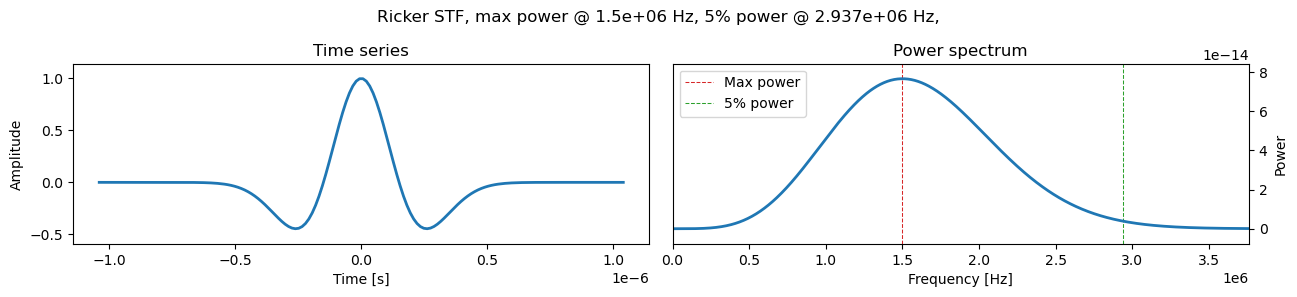

[2025-01-30 14:53:49,891] INFO: This exact entity is already part of the project. Nothing will be done. The comparison to the existing mesh was fairly expensive as it is (depending on the mesh size) a large amount of data that has to be compared. So best only add it once!


In [42]:
stf = sn.simple_config.stf.Ricker(center_frequency=CENTRAL_FREQUENCY)

stf.plot()

end_time = 5e-5 # 50 mu s

sc = sn.UnstructuredMeshSimulationConfiguration(
    unstructured_mesh=mesh,
    name="sc_mesh_1",
    # Event specific configuration.
    event_configuration=sn.EventConfiguration(
        # Source wavelet.
        wavelet=stf,
        waveform_simulation_configuration=sn.WaveformSimulationConfiguration(
            end_time_in_seconds=end_time
        ),
    ),
)

# p.entities.delete(entity_name="sc_mesh_1", entity_type="simulation_configuration")

p += sc

In [43]:
p.viz.nb.simulation_setup(
    simulation_configuration="sc_mesh_1", events=f"array_a_source_{source_id}"
)

## Simulating with volumetric output

In [57]:
output_conf = {
    "volume_data": {
        "sampling_interval_in_time_steps": int(0.25 * CENTRAL_FREQUENCY / 1e3),
        # Will need two fields, as velocity is elastic and phi_t is acoustic
        "fields": ["velocity", "phi_t"],
    }
}

source_id = 14
p.simulations.launch(
    simulation_configuration="sc_mesh_1",
    events=f"array_a_source_{source_id}",
    site_name=SITE_NAME,
    ranks_per_job=RANKS,
    extra_output_configuration=output_conf,
    delete_conflicting_previous_results=True,
)

p.simulations.query(block=True)

[2025-01-30 15:04:31,594] INFO: delete_conflicting_previous_results is set to True. Deleting results for simulation configuration sc_mesh_1 and event array_a_source_14.
[2025-01-30 15:04:31,599] INFO: Removing contents of `project_03_1500000/EVENTS/array_a_source_14/WAVEFORM_DATA/INTERNAL/82/c8/a4d9e90657b8`.
[2025-01-30 15:04:31,644] INFO: Submitting job ...
Uploading 1 files...

🚀  Submitted job_2501301504650704_5c70f9c938@local


VBox()

True

## Visualizing the wavefield

This is a little harder, as we have a elastic and acoustic wavefield.

In [58]:
source_id = 14
output_path = p.simulations.get_simulation_output_directory(
    simulation_configuration="sc_mesh_1",
    event=f"array_a_source_{source_id}",
)

output_path

PosixPath('project_03_1500000/EVENTS/array_a_source_14/WAVEFORM_DATA/INTERNAL/82/c8/a4d9e90657b8')

In [59]:
from salvus.toolbox.helpers.wavefield_output import WavefieldOutput

wavefield_pixel_height = 0.00015

# Extract wavefield the solid
wo_solid = WavefieldOutput.from_file(
    output_path / "volume_data_output.h5",
    field="velocity",
    output_type="volume",
)
wf_solid = sn.wavefield_output_to_xarray(
    wo_solid,
    (
        np.linspace(0, 0.1, 401),
        np.linspace(
            0,
            0.03 - interface_depth,
            int((0.03 - interface_depth) / wavefield_pixel_height),
        ),
    ),
    mode="sequential",
)
wf_solid /= np.abs(wf_solid).max()


# Extract wavefield in the fluid
wo_fluid = WavefieldOutput.from_file(
    output_path / "volume_data_output.h5", field="phi_t", output_type="volume"
)
wf_fluid = sn.wavefield_output_to_xarray(
    wo_fluid,
    (
        np.linspace(0, 0.1, 401),
        np.linspace(
            0.03 - interface_depth,
            0.03,
            int(interface_depth / wavefield_pixel_height),
        ),
    ),
    mode="sequential",
)
wf_fluid /= np.abs(wf_fluid).max()

# Combine the normalized wavefields
wf = xr.concat([wf_solid, wf_fluid], dim="y")

Finding enclosing elements (pass 1 of auto):   0%|          | 0/66566 [00:00<?, ?it/s]

Finding enclosing elements (pass 2 of auto):   0%|          | 0/28 [00:00<?, ?it/s]

Extracting wavefield to regular grid:   0%|          | 0/11535 [00:00<?, ?it/s]

Finding enclosing elements (pass 1 of auto):   0%|          | 0/13233 [00:00<?, ?it/s]

Extracting wavefield to regular grid:   0%|          | 0/8020 [00:00<?, ?it/s]

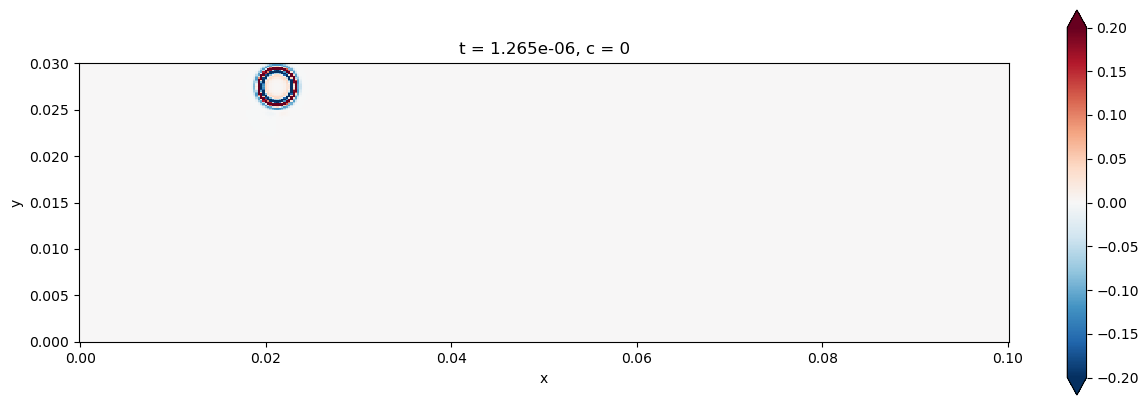

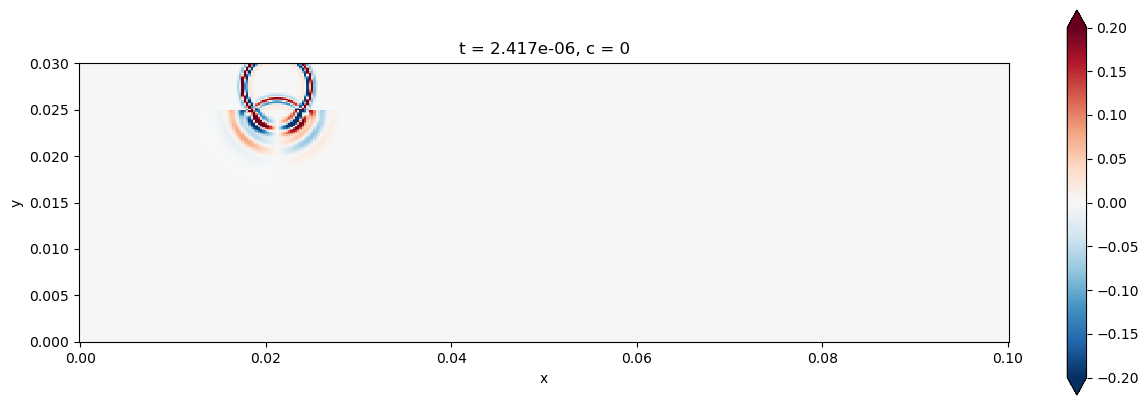

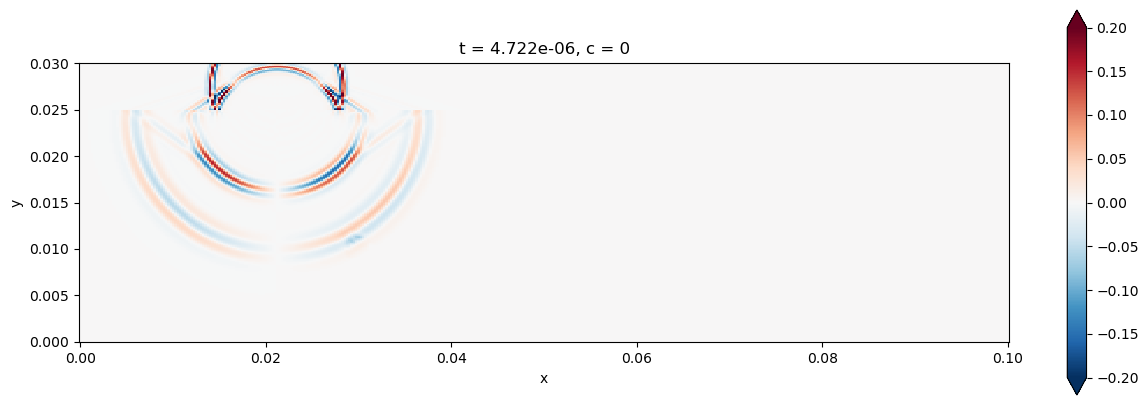

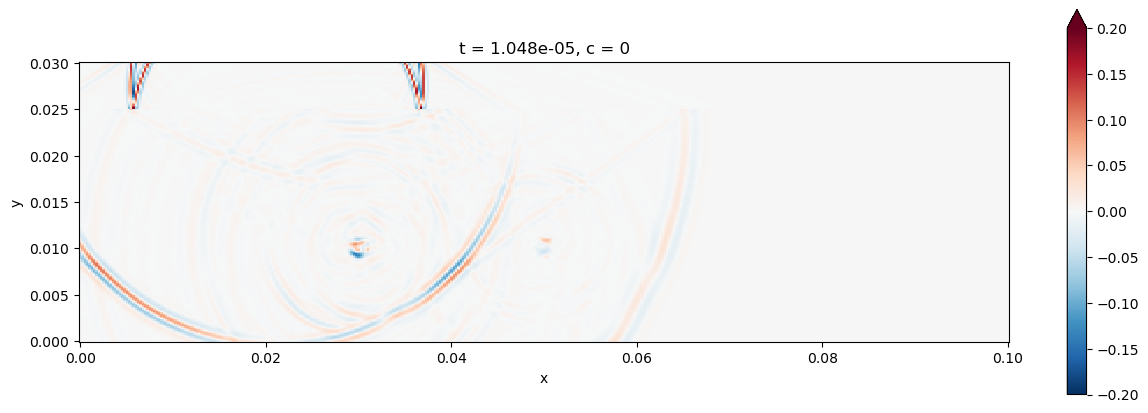

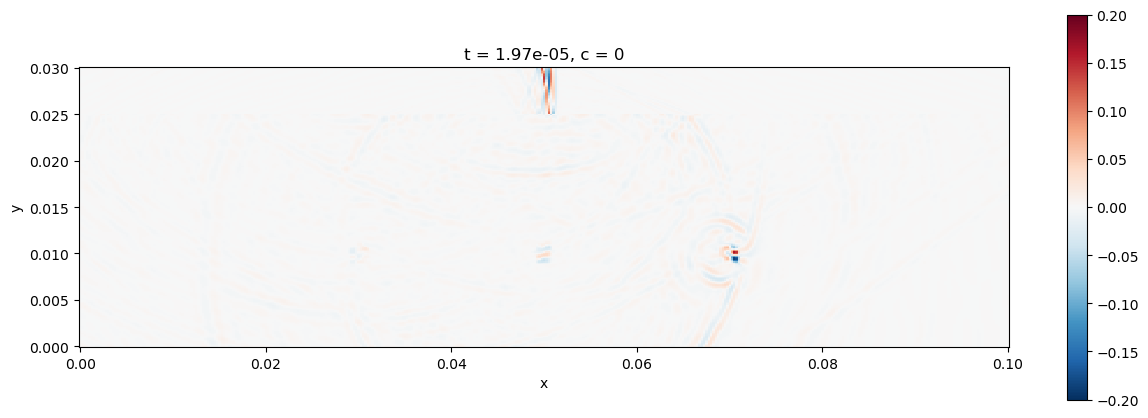

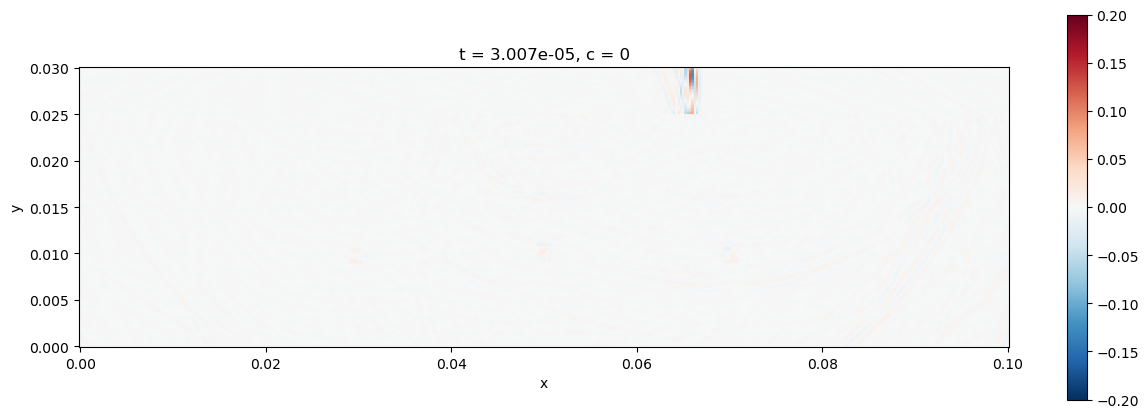

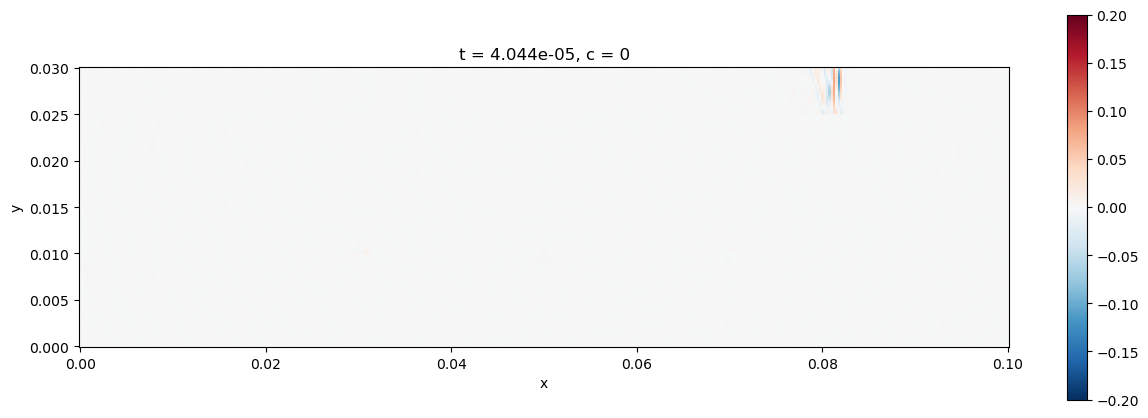

In [61]:
for t in [0.125e-5, 0.25e-5, 0.5e-5, 1e-5, 2e-5, 3e-5, 4e-5]:
    wf.sel(t=t, c=0, method="nearest").T.plot(
        aspect=1, figsize=(15, 5), vmax=0.2
    )
    plt.gca().set_aspect("equal")

## 2-D data analysis

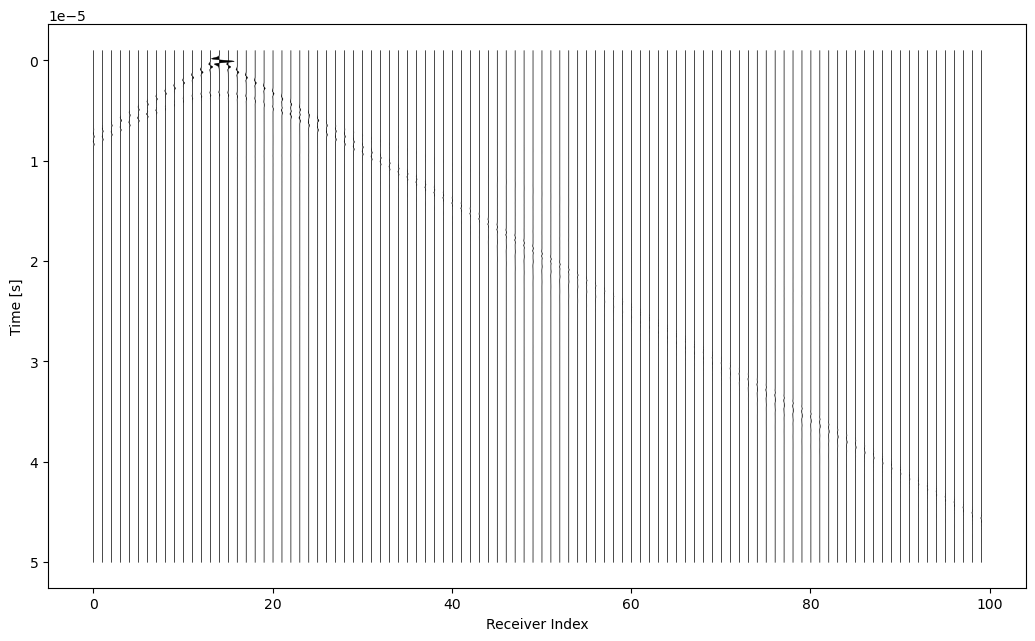

In [62]:
event_data = p.waveforms.get("sc_mesh_1", f"array_a_source_{source_id}")[0]

event_data.plot(receiver_field="phi", component="A")

That's hard to see! Reason for it is that the wave **at** the source has a really high amplitude. Let's instead plot the wavefield as an image with a fixed maximum:

In [63]:
pressure_data = event_data.get_waveform_data_xarray(receiver_field="phi")

(5e-05, 0.0)

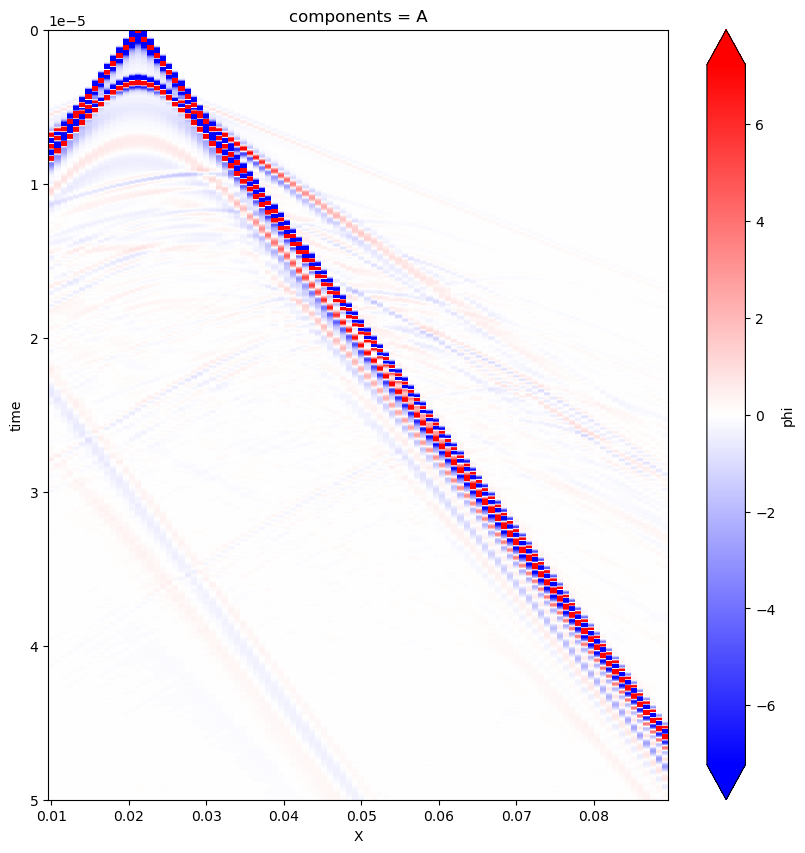

In [64]:
# Instead of labelling the trace with the receiver_ids, label them with x-coordinate.
pressure_data_for_plot = (
    pressure_data.sortby("receiver_ids")
    .assign_coords(receiver_ids=np.sort(pressure_data.location[:, 0]))
    .rename({"receiver_ids": "X"})
).sortby("X")


extremum = np.abs(pressure_data_for_plot).max() / 100

# Plot with the updated coordinates
pressure_data_for_plot.T.plot(
    vmax=extremum, vmin=-extremum, cmap="bwr", figsize=(10, 10)
)

plt.ylim([5e-5, 0])

In [ ]:
sn.UnstructuredMesh.from_h5()

In [67]:
mesh.elemental_fields.clear()

In [69]:
mesh.write_h5("exported_salvus_mesh.h5")

In [79]:
grain_map = ...

# mesh.change_tensor_order(4)

C11 = np.linalg.norm(mesh.points[mesh.connectivity], axis=-1)

In [96]:
C11[:, ...] = np.random.randn(*(26400, 25))

In [97]:
mesh.attach_field("C11",C11)

In [98]:
mesh

In [99]:
import scipy.spatial

In [103]:
vn = scipy.spatial.Voronoi([[0,0], [0.1,0.03], [0.1,0.013], [0.05,0.03]])

In [105]:
vn.point_region?

Type:        ndarray
String form: [2 3 4 0]
Length:      4
File:        ~/miniforge3/envs/salvus_x86_2024.1.2/lib/python3.11/site-packages/numpy/__init__.py
Docstring:  
ndarray(shape, dtype=float, buffer=None, offset=0,
        strides=None, order=None)

An array object represents a multidimensional, homogeneous array
of fixed-size items.  An associated data-type object describes the
format of each element in the array (its byte-order, how many bytes it
occupies in memory, whether it is an integer, a floating point number,
or something else, etc.)

Arrays should be constructed using `array`, `zeros` or `empty` (refer
to the See Also section below).  The parameters given here refer to
a low-level method (`ndarray(...)`) for instantiating an array.

For more information, refer to the `numpy` module and examine the
methods and attributes of an array.

Parameters
----------
(for the __new__ method; see Notes below)

shape : tuple of ints
    Shape of created array.
dtype : data-type, opti